This notebook borrows code and logic from the following sources: 
- https://github.com/propublica/compas-analysis 
- https://investigate.ai/propublica-criminal-sentencing/week-5-1-machine-bias-class/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import det_curve

# 1. Data Preparation

Data preparation follows the steps described in Propublica's own implementation:

In [2]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
raw = pd.read_csv(url)

In [4]:
cols = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
    'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
df = raw.loc[
    (raw.days_b_screening_arrest <= 30) &  
    (raw.days_b_screening_arrest >= -30) &  
    (raw.is_recid != -1) &
    (raw.c_charge_degree != 'O') &
    (raw.score_text != 'N/A'),
    cols].reset_index()
df.head()

,index,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
4,6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


# 2. Data understanding

## 2.1 COMPAS Scores

The `decile_score` measures on a scale between 1 (low) and 10 (high) the risk of recidivism of defendants. It was calculated by the company Northpointe as part of their product **COMPAS** (Correctional Offender Management Profiling for Alternative Sanctions). The algorithm used by Northpointe is not publicly known. 

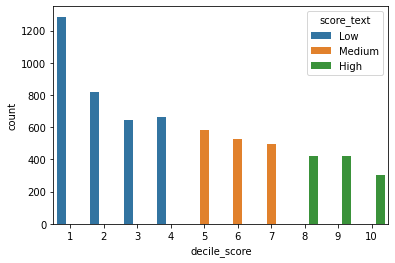

In [5]:
sns.countplot(x='decile_score', hue='score_text', data = df);

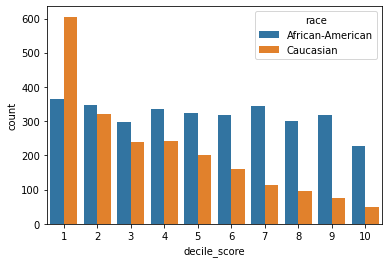

In [6]:
sns.countplot(x='decile_score', hue='race', data=df[(df.race.isin(['African-American','Caucasian']))]);

## 2.2. Actual Recidivism 

The binary variable `two_year_recid` measures whether defendants have recidivated within the two years following the original imprisonment. Recidividating requires a crime that again leads to imprisonment. 

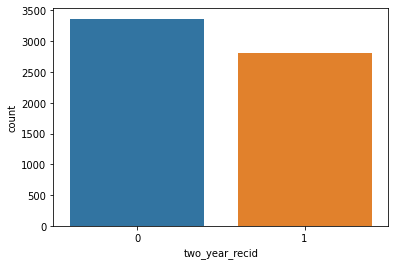

In [44]:
sns.countplot(x='two_year_recid', data = df);

What is the fraction of defendants who recidivate within 2 years for the different races? In a perfect world (with true **equality of opportunities**), we would expect these rates to be identical across races. This is, we would expect **equality of outcomes**.

In [7]:
recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


## 2.3 Compas Score and actual recidivism 

Calibrated probabilities: for a given decile score, the actual recidivism rates increase monotonically, and - approximatly - a 1 percentage point increase in the decile score corresponds to a 1 percentage point increase in actual recidivism.

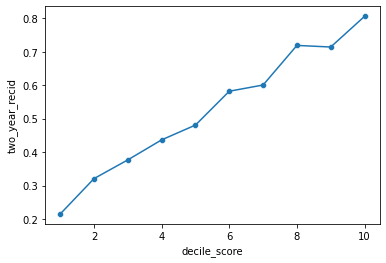

In [9]:
p = df.groupby('decile_score').agg({'two_year_recid': 'mean'}).reset_index()
sns.lineplot(data = p, x='decile_score', y = 'two_year_recid');
sns.scatterplot(data = p, x='decile_score', y = 'two_year_recid', legend=None);

 In this regard there are no strong systemmatic differences between blacks and whites.

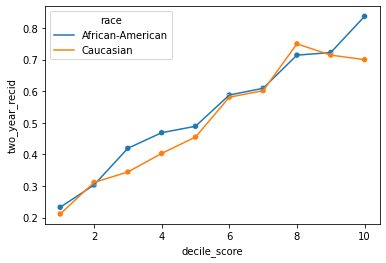

In [46]:
p = df[df.race.isin(["African-American","Caucasian"])].groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}).reset_index()
sns.lineplot(data = p, x='decile_score', y = 'two_year_recid', hue='race');
sns.scatterplot(data = p, x='decile_score', y = 'two_year_recid', hue='race', legend=None);

For given actual recidivism state, we observe differences between black and white defendants:
- Black defendants who do not recidivate receive on average a higher compas score than whites. They are thus more often mis-classified as dangerous and put into jail.
- White reoffenders receive on average a lower compas score than black reoffenders. Hence, they will be more often mis-classified and wrongly set free. 

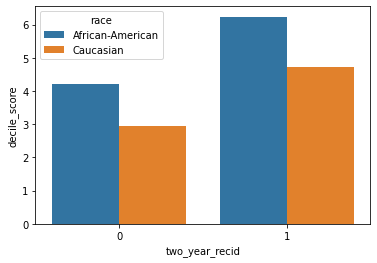

In [10]:
p = df[df.race.isin(["African-American","Caucasian"])].groupby(['race','two_year_recid']).agg({'decile_score': 'mean'}).reset_index()
sns.barplot(data = p, y='decile_score', x = 'two_year_recid', hue='race');

## 2.4 Confusion matrix and evaluation metrics

We set a threshold (5) for the decile score. Defendants with compas scores at or above the threshold are considered medium to high risk of recidivism. This score might be taken to deny them bail.

In [11]:
threshold = 5
df['guessed_recid'] = df.decile_score>=threshold
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid, margins=True)
cm

guessed_recid,False,True,All
actual_recid,,,
False,2345,1018,3363
True,1076,1733,2809
All,3421,2751,6172


In [17]:
print("Accuracy: ", (1733+2345) / 6172)
print("Faction of people classified correctly.", end='\n\n')

print("False Positive Rate: ", 1018 / 3363)  
print("Fraction of actually harmless people that we (wrongly) take away their freedom.", end='\n\n')

print("False Negative Rate: ", 1076 / 2809)
print("Faction of actually dangerous people that we (wrongly) set free.", end='\n\n')

print("Positive Predicted Value: ", 1733 / 2751)
print("Faction of people predicted dangerous, that are in fact dangerous.")

Accuracy:  0.6607258587167855
Faction of people classified correctly.

False Positive Rate:  0.30270591733571217
Fraction of actually harmless people that we (wrongly) take away their freedom.

False Negative Rate:  0.38305446778212887
Faction of actually dangerous people that we (wrongly) set free.

Positive Predicted Value:  0.6299527444565612
Faction of people predicted dangerous, that are in fact dangerous.


In [33]:
def eval_metrics(df, actual, guessed):

    cm = pd.crosstab(df[actual], df[guessed], rownames=['actual'], colnames=['guessed'])
    TP = cm.loc[1,1]     # Guessed positive and actual positive
    FP = cm.loc[0,1]     # Guessed positive and actual negative (-> false guess)
    TN = cm.loc[0,0]     # Guessed negative and actual negative
    FN = cm.loc[1,0]     # Guessed negative and actual positive (-> false guess)
    metrics = pd.Series({
        'Accuracy':(TN+TP)/(TN+TP+FN+FP),
        'PPV': TP / (TP + FP),
        'FPR': FP / (FP + TN),
        'FNR': FN / (FN + TP)})
    return metrics
    

While the accuracy and the positive predicted values are largely the same for white and black defendants, we observe huge differences with respect to false positive rates and false negative rates: 1) black defandants who do not recidivate are more often mis-classified than whites (FPR) and 2) white reoffenders are more often mis-classified as harmless than black reoffenders (FNR). 

In [34]:
df[df.race.isin(['African-American','Caucasian'])].groupby("race").apply(eval_metrics, "actual_recid", "guessed_recid").round(2).T

race,African-American,Caucasian
Accuracy,0.65,0.67
PPV,0.65,0.59
FPR,0.42,0.22
FNR,0.28,0.50


# 3. Building own predictor

## 3.1. Disparate treatment
Now we study, how a score such as the COMPAS score may have been created in the first place. First, we include **race** explicitly as a model input. Note: this is something that was *not* done by Northpoint. Using such as model for court decisions would amount to a deliberate discrimination (**direct discrimination** in German law, **disparate treatment** in US law) on the basis of race.

In [35]:
# build up dummy variables for age, race, gender
features = pd.concat(
    [pd.get_dummies(df.age_cat, prefix='age', drop_first=True),
     pd.get_dummies(df.sex, prefix='sex', drop_first=True),
     pd.get_dummies(df.c_charge_degree, prefix='degree', drop_first=True),
     pd.get_dummies(df.race, prefix='race', drop_first=True),
     df.priors_count],
    axis=1)
x = features.to_numpy()
y = df.two_year_recid.to_numpy()  
lr = LogisticRegression()
lr.fit(x,y) 

LogisticRegression()

According to our logistic regression, the **odds** of recidivism are: 

- 2 times higher for people <25 years compared to people betwenn 25 and 45 years (all other things equal)
- 1.4 times higher for males compared to woman (all other things equal)
- only 90% for whites and 57% for asians compared to black defendants

In [39]:
coeffs = pd.DataFrame(np.exp(lr.coef_), columns=features.columns)
coeffs.round(3)

,age_Greater than 45,age_Less than 25,sex_Male,degree_M,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,priors_count
0,0.514,2.077,1.414,0.804,0.578,0.91,0.77,0.773,0.782,1.18


## 3.2 Disparate impact

Second, we do not include **race** into our model. We want to study, whether we still observe a **disparate impact** for black defendants due to correlated variables. Maybe, black defendants are on average younger than white defendants, such that the variable age serves as a proxy for black.

In [64]:
# build up dummy variables for age, race, gender
features = pd.concat(
    [pd.get_dummies(df.age_cat, prefix='age', drop_first=True),
     pd.get_dummies(df.sex, prefix='sex', drop_first=True),
     pd.get_dummies(df.c_charge_degree, prefix='degree', drop_first=True),
     df.priors_count],
    axis=1)
x = features.to_numpy()
y = df.two_year_recid.to_numpy()  
lr = LogisticRegression()
lr.fit(x,y)

LogisticRegression()

In [75]:
# Confusion matrix for our predictive model
df['own_prediction'] = lr.predict(x)==1
cm = pd.crosstab(df.actual_recid, df.own_prediction, rownames=['actual'], colnames=['guessed'])
cm

guessed,False,True
actual,,
False,2568,795
True,1239,1570


In [79]:
df[df.race.isin(['African-American','Caucasian'])].groupby('race').apply(eval_metrics, "actual_recid", "own_prediction")

,Accuracy,PPV,FPR,FNR
race,,,,
African-American,0.668661,0.692114,0.322325,0.339554
Caucasian,0.663814,0.606285,0.166276,0.600973
